# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [0,1]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [2, 3, 4, 5, 6, 7, 8, 9] rm: [0, 1]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.193
[2] loss: 0.138
[3] loss: 0.045
[4] loss: 0.026
[5] loss: 0.018
[6] loss: 0.013
[7] loss: 0.009
[8] loss: 0.010
[9] loss: 0.010
[10] loss: 0.006
[11] loss: 0.005
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.004
[15] loss: 0.003
[16] loss: 0.005
[17] loss: 0.003
[18] loss: 0.004
[19] loss: 0.002
[20] loss: 0.005


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

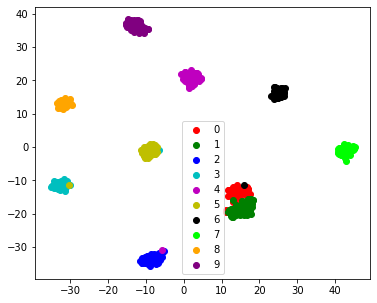

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

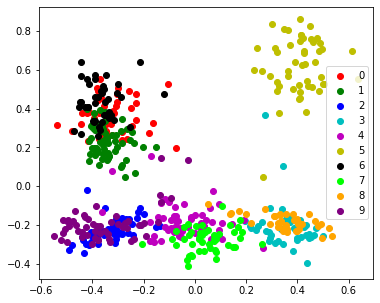

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.3467,  0.3665, -0.0572,  0.3735, -0.3530,  0.0283,  0.3403, -0.3873,
         -0.3444],
        [-0.1665, -0.2540,  0.4606, -0.0964, -0.2172,  0.2923, -0.0317,  0.4875,
         -0.1360],
        [-0.2350, -0.2209, -0.1741,  0.6388,  0.4284, -0.2636, -0.1762, -0.2083,
          0.3011],
        [-0.1501,  0.0268, -0.1860, -0.1828,  0.4186,  0.5566, -0.1465, -0.1777,
          0.1097],
        [ 0.2039, -0.3396, -0.3236, -0.3284, -0.1336, -0.2316,  0.5259, -0.1393,
          0.2453],
        [ 0.3464, -0.1591,  0.4660, -0.1655, -0.2699, -0.1793, -0.2963, -0.2699,
          0.1306],
        [-0.2208,  0.1809, -0.2378, -0.1923, -0.2207,  0.0140, -0.1731,  0.4609,
          0.4382],
        [ 0.1852,  0.3318, -0.4171, -0.2059,  0.2455, -0.2941, -0.2239,  0.1170,
         -0.3825]])

In [13]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [18]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_0,1_unk.cfg')

['./config/sswae_dev2_rm_0,1_unk.cfg']

In [19]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 0,1
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.512491e-01  D: 6.918972e-01  D2: 5.284395e-02  D3: 3.639950e-03
test loss: 1.893611e-01  D: 6.910209e-01  D2: 2.457719e-02  D3: 6.574404e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.723652e-01  D: 6.940265e-01  D2: 1.445830e-02  D3: 7.502089e-03
test loss: 1.572191e-01  D: 6.983557e-01  D2: 8.726664e-03  D3: 7.739711e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.501475e-01  D: 6.944782e-01  D2: 4.112069e-03  D3: 7.563054e-03
test loss: 1.337193e-01  D: 7.020162e-01  D2: 1.303720e-03  D3: 6.855404e-03


[default |INFO|model.py:1823] [04/80]  loss: 1.203359e-01  D: 6.941604e-01  D2: -6.562440e-04  D3: 6.573276e-03
test loss: 1.071060e-01  D: 7.062860e-01  D2: -2.223759e-03  D3: 4.257268e-03


[default |INFO|model.py:1823] [05/80]  loss: 1.014149e-01  D: 6.932335e-01  D2: -2.808415e-03  D3: 6.452976e-03
test loss: 9.016001e-02  D: 7.025668e-01  D2: -2.826290e-03  D3: 6.204296e-03


[default |INFO|model.py:1823] [06/80]  loss: 9.392067e-02  D: 6.954288e-01  D2: -3.814047e-03  D3: 7.142163e-03
test loss: 9.001997e-02  D: 7.012121e-01  D2: -4.131165e-03  D3: 6.627950e-03


[default |INFO|model.py:1823] [07/80]  loss: 8.371666e-02  D: 6.934993e-01  D2: -4.402138e-03  D3: 7.702479e-03
test loss: 8.002910e-02  D: 6.837181e-01  D2: -4.583035e-03  D3: 7.969013e-03


[default |INFO|model.py:1823] [08/80]  loss: 7.701730e-02  D: 6.930298e-01  D2: -4.641808e-03  D3: 7.900009e-03
test loss: 8.465345e-02  D: 6.864158e-01  D2: -4.767523e-03  D3: 9.468692e-03


[default |INFO|model.py:1823] [09/80]  loss: 8.293883e-02  D: 6.959640e-01  D2: -4.828645e-03  D3: 9.808107e-03
test loss: 8.037224e-02  D: 7.265720e-01  D2: -5.497084e-03  D3: 1.187743e-02


[default |INFO|model.py:1823] [10/80]  loss: 8.392452e-02  D: 6.944799e-01  D2: -4.774281e-03  D3: 1.385969e-02
test loss: 7.805624e-02  D: 6.985389e-01  D2: -5.727930e-03  D3: 1.366867e-02


[default |INFO|model.py:1823] [11/80]  loss: 7.783080e-02  D: 6.931753e-01  D2: -5.517082e-03  D3: 1.177809e-02
test loss: 7.288521e-02  D: 6.830659e-01  D2: -5.508356e-03  D3: 1.161147e-02


[default |INFO|model.py:1823] [12/80]  loss: 7.531863e-02  D: 6.924373e-01  D2: -5.747293e-03  D3: 1.329898e-02
test loss: 6.997751e-02  D: 6.853945e-01  D2: -5.788822e-03  D3: 1.354332e-02


[default |INFO|model.py:1823] [13/80]  loss: 7.063405e-02  D: 6.933445e-01  D2: -5.868864e-03  D3: 1.412302e-02
test loss: 6.549156e-02  D: 6.914003e-01  D2: -6.650105e-03  D3: 1.393352e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.826808e-02  D: 6.944004e-01  D2: -6.262237e-03  D3: 1.371649e-02
test loss: 6.620087e-02  D: 6.867209e-01  D2: -5.976572e-03  D3: 1.561296e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.776921e-02  D: 6.944144e-01  D2: -6.316628e-03  D3: 1.376807e-02
test loss: 6.702625e-02  D: 6.988487e-01  D2: -6.531076e-03  D3: 1.244093e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.778720e-02  D: 6.927195e-01  D2: -6.495830e-03  D3: 1.286162e-02
test loss: 6.609856e-02  D: 6.870110e-01  D2: -6.183729e-03  D3: 1.185891e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.501328e-02  D: 6.951705e-01  D2: -6.526798e-03  D3: 1.316867e-02
test loss: 6.556135e-02  D: 7.138614e-01  D2: -5.745850e-03  D3: 1.415136e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.345499e-02  D: 6.938865e-01  D2: -6.652039e-03  D3: 1.383233e-02
test loss: 6.212236e-02  D: 6.941264e-01  D2: -7.437906e-03  D3: 1.400709e-02


[default |INFO|model.py:1823] [19/80]  loss: 6.241899e-02  D: 6.942342e-01  D2: -6.816339e-03  D3: 1.353757e-02
test loss: 6.140635e-02  D: 6.990148e-01  D2: -6.877737e-03  D3: 1.425224e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.999948e-02  D: 6.940219e-01  D2: -7.056025e-03  D3: 1.365982e-02
test loss: 6.104406e-02  D: 7.061513e-01  D2: -6.907911e-03  D3: 1.406928e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.972660e-02  D: 6.928928e-01  D2: -7.099268e-03  D3: 1.354791e-02
test loss: 6.071193e-02  D: 6.749358e-01  D2: -6.709642e-03  D3: 1.268567e-02


[default |INFO|model.py:1823] [22/80]  loss: 6.044690e-02  D: 6.942844e-01  D2: -7.364235e-03  D3: 1.329208e-02
test loss: 5.770608e-02  D: 7.035110e-01  D2: -7.541294e-03  D3: 1.335234e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.870239e-02  D: 6.931851e-01  D2: -7.300049e-03  D3: 1.349647e-02
test loss: 5.687051e-02  D: 6.891311e-01  D2: -7.385654e-03  D3: 1.252017e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.716994e-02  D: 6.934939e-01  D2: -7.516688e-03  D3: 1.361975e-02
test loss: 5.744799e-02  D: 6.870039e-01  D2: -7.251940e-03  D3: 1.226736e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.638503e-02  D: 6.935890e-01  D2: -7.568781e-03  D3: 1.369613e-02
test loss: 5.744956e-02  D: 6.984945e-01  D2: -7.686262e-03  D3: 1.335143e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.641614e-02  D: 6.930057e-01  D2: -7.780377e-03  D3: 1.366661e-02
test loss: 5.580549e-02  D: 6.931296e-01  D2: -7.938194e-03  D3: 1.253880e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.572936e-02  D: 6.939012e-01  D2: -7.896493e-03  D3: 1.331969e-02
test loss: 5.524727e-02  D: 7.050782e-01  D2: -8.142815e-03  D3: 1.249484e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.663049e-02  D: 6.940057e-01  D2: -7.868512e-03  D3: 1.315872e-02
test loss: 5.574085e-02  D: 7.051264e-01  D2: -8.371658e-03  D3: 1.413065e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.495264e-02  D: 6.938107e-01  D2: -8.059416e-03  D3: 1.303360e-02
test loss: 5.437941e-02  D: 6.924130e-01  D2: -8.242111e-03  D3: 1.291291e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.365348e-02  D: 6.935090e-01  D2: -8.106133e-03  D3: 1.330420e-02
test loss: 5.385555e-02  D: 7.070827e-01  D2: -8.023548e-03  D3: 1.333606e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.417061e-02  D: 6.933417e-01  D2: -8.154291e-03  D3: 1.331536e-02
test loss: 5.255966e-02  D: 6.906025e-01  D2: -8.373585e-03  D3: 1.309860e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.311752e-02  D: 6.933613e-01  D2: -8.242172e-03  D3: 1.322939e-02
test loss: 5.371913e-02  D: 6.812044e-01  D2: -8.088007e-03  D3: 1.496657e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.322700e-02  D: 6.933547e-01  D2: -8.156913e-03  D3: 1.296902e-02
test loss: 5.517459e-02  D: 6.987913e-01  D2: -8.197012e-03  D3: 1.284459e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.238091e-02  D: 6.936380e-01  D2: -8.441269e-03  D3: 1.303081e-02
test loss: 5.238901e-02  D: 6.826040e-01  D2: -8.303137e-03  D3: 1.297453e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.337553e-02  D: 6.939918e-01  D2: -8.297669e-03  D3: 1.288756e-02
test loss: 5.246387e-02  D: 6.982303e-01  D2: -8.739510e-03  D3: 1.203719e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.299690e-02  D: 6.936910e-01  D2: -8.480827e-03  D3: 1.306719e-02
test loss: 5.426166e-02  D: 6.975380e-01  D2: -8.164110e-03  D3: 1.264116e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.130570e-02  D: 6.931648e-01  D2: -8.508503e-03  D3: 1.312019e-02
test loss: 5.457448e-02  D: 6.960528e-01  D2: -8.583279e-03  D3: 1.300772e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.127900e-02  D: 6.938259e-01  D2: -8.538324e-03  D3: 1.313503e-02
test loss: 5.245331e-02  D: 6.886143e-01  D2: -8.755436e-03  D3: 1.247425e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.083971e-02  D: 6.932431e-01  D2: -8.499276e-03  D3: 1.306323e-02
test loss: 5.259353e-02  D: 6.917163e-01  D2: -8.819704e-03  D3: 1.269811e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.087352e-02  D: 6.936073e-01  D2: -8.688049e-03  D3: 1.299550e-02
test loss: 5.306848e-02  D: 6.979324e-01  D2: -8.163157e-03  D3: 1.284211e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.057891e-02  D: 6.930255e-01  D2: -8.758562e-03  D3: 1.291451e-02
test loss: 5.207292e-02  D: 6.898062e-01  D2: -8.789291e-03  D3: 1.226725e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.040993e-02  D: 6.935410e-01  D2: -8.817849e-03  D3: 1.284065e-02
test loss: 5.121105e-02  D: 6.880878e-01  D2: -9.062805e-03  D3: 1.438773e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.028971e-02  D: 6.933404e-01  D2: -8.814866e-03  D3: 1.290967e-02
test loss: 5.056376e-02  D: 6.956257e-01  D2: -9.163971e-03  D3: 1.318504e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.039946e-02  D: 6.936135e-01  D2: -8.872356e-03  D3: 1.280965e-02
test loss: 5.168934e-02  D: 6.961017e-01  D2: -9.027138e-03  D3: 1.251621e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.026618e-02  D: 6.933231e-01  D2: -8.888887e-03  D3: 1.271946e-02
test loss: 5.116231e-02  D: 6.937409e-01  D2: -8.908606e-03  D3: 1.381380e-02


[default |INFO|model.py:1823] [46/80]  loss: 4.976047e-02  D: 6.931864e-01  D2: -8.942518e-03  D3: 1.281931e-02
test loss: 5.042862e-02  D: 6.847335e-01  D2: -8.612909e-03  D3: 1.415353e-02


[default |INFO|model.py:1823] [47/80]  loss: 4.987558e-02  D: 6.937334e-01  D2: -8.949749e-03  D3: 1.264926e-02
test loss: 5.400583e-02  D: 6.886278e-01  D2: -9.135532e-03  D3: 1.114816e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.123344e-02  D: 6.937141e-01  D2: -9.033251e-03  D3: 1.246648e-02
test loss: 5.138748e-02  D: 7.008105e-01  D2: -8.764133e-03  D3: 1.285719e-02


[default |INFO|model.py:1823] [49/80]  loss: 4.961029e-02  D: 6.933068e-01  D2: -9.072949e-03  D3: 1.263277e-02
test loss: 5.184706e-02  D: 6.905829e-01  D2: -8.861208e-03  D3: 1.247551e-02


[default |INFO|model.py:1823] [50/80]  loss: 4.969483e-02  D: 6.936255e-01  D2: -9.075465e-03  D3: 1.256184e-02
test loss: 5.280346e-02  D: 6.944779e-01  D2: -8.917017e-03  D3: 1.232715e-02


[default |INFO|model.py:1823] [51/80]  loss: 4.925103e-02  D: 6.937164e-01  D2: -9.149041e-03  D3: 1.258919e-02
test loss: 5.062303e-02  D: 6.919865e-01  D2: -9.139652e-03  D3: 1.313691e-02


[default |INFO|model.py:1823] [52/80]  loss: 4.890220e-02  D: 6.932146e-01  D2: -9.207196e-03  D3: 1.247141e-02
test loss: 5.190665e-02  D: 6.994619e-01  D2: -9.009190e-03  D3: 1.205413e-02


[default |INFO|model.py:1823] [53/80]  loss: 4.900606e-02  D: 6.934374e-01  D2: -9.153169e-03  D3: 1.258961e-02
test loss: 5.200779e-02  D: 6.956230e-01  D2: -9.119568e-03  D3: 1.153112e-02


[default |INFO|model.py:1823] [54/80]  loss: 4.876367e-02  D: 6.929219e-01  D2: -9.238601e-03  D3: 1.250143e-02
test loss: 5.249893e-02  D: 6.949947e-01  D2: -9.266520e-03  D3: 1.069026e-02


[default |INFO|model.py:1823] [55/80]  loss: 4.868439e-02  D: 6.936411e-01  D2: -9.225136e-03  D3: 1.246040e-02
test loss: 4.945803e-02  D: 6.912084e-01  D2: -9.466362e-03  D3: 1.221166e-02


[default |INFO|model.py:1823] [56/80]  loss: 4.832922e-02  D: 6.932627e-01  D2: -9.322974e-03  D3: 1.247150e-02
test loss: 5.054511e-02  D: 6.906915e-01  D2: -9.145994e-03  D3: 1.157897e-02


[default |INFO|model.py:1823] [57/80]  loss: 4.862325e-02  D: 6.931883e-01  D2: -9.347588e-03  D3: 1.240407e-02
test loss: 5.168395e-02  D: 6.919949e-01  D2: -9.120483e-03  D3: 1.107796e-02


[default |INFO|model.py:1823] [58/80]  loss: 4.883082e-02  D: 6.935433e-01  D2: -9.301049e-03  D3: 1.233661e-02
test loss: 5.003179e-02  D: 6.856255e-01  D2: -9.503279e-03  D3: 1.130235e-02


[default |INFO|model.py:1823] [59/80]  loss: 4.884002e-02  D: 6.935140e-01  D2: -9.295828e-03  D3: 1.232359e-02
test loss: 5.151736e-02  D: 6.965339e-01  D2: -9.477091e-03  D3: 1.111849e-02


[default |INFO|model.py:1823] [60/80]  loss: 4.825197e-02  D: 6.932362e-01  D2: -9.454074e-03  D3: 1.231156e-02
test loss: 5.137336e-02  D: 6.817524e-01  D2: -9.385900e-03  D3: 1.206459e-02


[default |INFO|model.py:1823] [61/80]  loss: 4.812628e-02  D: 6.933374e-01  D2: -9.397742e-03  D3: 1.226054e-02
test loss: 5.027826e-02  D: 6.923266e-01  D2: -9.345493e-03  D3: 1.184500e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.802068e-02  D: 6.934029e-01  D2: -9.495101e-03  D3: 1.230785e-02
test loss: 5.136585e-02  D: 6.882882e-01  D2: -9.457941e-03  D3: 1.226229e-02


[default |INFO|model.py:1823] [63/80]  loss: 4.841888e-02  D: 6.936425e-01  D2: -9.493756e-03  D3: 1.217372e-02
test loss: 4.955961e-02  D: 6.951356e-01  D2: -9.704132e-03  D3: 1.307254e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.783397e-02  D: 6.936532e-01  D2: -9.430327e-03  D3: 1.216001e-02
test loss: 4.930136e-02  D: 6.758039e-01  D2: -9.587431e-03  D3: 1.268213e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.758687e-02  D: 6.934310e-01  D2: -9.506267e-03  D3: 1.227249e-02
test loss: 5.064480e-02  D: 6.897870e-01  D2: -9.457588e-03  D3: 1.269652e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.774427e-02  D: 6.929154e-01  D2: -9.590697e-03  D3: 1.202280e-02
test loss: 5.058698e-02  D: 6.939692e-01  D2: -9.316759e-03  D3: 1.149766e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.764256e-02  D: 6.932472e-01  D2: -9.521330e-03  D3: 1.216540e-02
test loss: 5.210305e-02  D: 6.959215e-01  D2: -9.184790e-03  D3: 1.191697e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.821008e-02  D: 6.934458e-01  D2: -9.589146e-03  D3: 1.199649e-02
test loss: 5.041206e-02  D: 7.006244e-01  D2: -9.541721e-03  D3: 1.348047e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.800115e-02  D: 6.934288e-01  D2: -9.603610e-03  D3: 1.194623e-02
test loss: 5.040457e-02  D: 6.868937e-01  D2: -9.731731e-03  D3: 1.329070e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.803154e-02  D: 6.938371e-01  D2: -9.603670e-03  D3: 1.212000e-02
test loss: 5.036518e-02  D: 6.888321e-01  D2: -9.591789e-03  D3: 1.154154e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.770110e-02  D: 6.931618e-01  D2: -9.693968e-03  D3: 1.207572e-02
test loss: 4.859352e-02  D: 6.809159e-01  D2: -9.592676e-03  D3: 1.224941e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.766228e-02  D: 6.935968e-01  D2: -9.645514e-03  D3: 1.206584e-02
test loss: 5.038787e-02  D: 6.885335e-01  D2: -9.606085e-03  D3: 1.217499e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.789772e-02  D: 6.930643e-01  D2: -9.648366e-03  D3: 1.195771e-02
test loss: 5.084952e-02  D: 6.898231e-01  D2: -9.340792e-03  D3: 1.199147e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.798069e-02  D: 6.931489e-01  D2: -9.672635e-03  D3: 1.195434e-02
test loss: 5.016920e-02  D: 6.939069e-01  D2: -9.731102e-03  D3: 1.179489e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.720818e-02  D: 6.933451e-01  D2: -9.746990e-03  D3: 1.194827e-02
test loss: 4.985405e-02  D: 6.936434e-01  D2: -9.784527e-03  D3: 1.234758e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.830197e-02  D: 6.939546e-01  D2: -9.767604e-03  D3: 1.189812e-02
test loss: 4.935818e-02  D: 6.943762e-01  D2: -9.628820e-03  D3: 1.095073e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.773939e-02  D: 6.934847e-01  D2: -9.722608e-03  D3: 1.185051e-02
test loss: 4.948909e-02  D: 6.962484e-01  D2: -9.817982e-03  D3: 1.134852e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.750965e-02  D: 6.931327e-01  D2: -9.719197e-03  D3: 1.178775e-02
test loss: 5.031735e-02  D: 6.939551e-01  D2: -9.740896e-03  D3: 1.049905e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.771175e-02  D: 6.936135e-01  D2: -9.778878e-03  D3: 1.180993e-02
test loss: 4.967397e-02  D: 7.079164e-01  D2: -9.877892e-03  D3: 1.203300e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.729346e-02  D: 6.931965e-01  D2: -9.715762e-03  D3: 1.191266e-02
test loss: 5.010877e-02  D: 6.912453e-01  D2: -9.810934e-03  D3: 1.177834e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 2054.656s


# Test

In [21]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [22]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [31]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

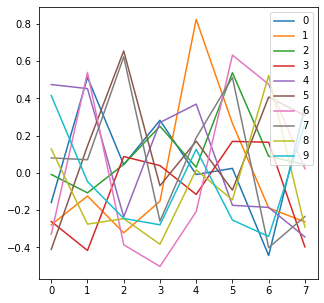

In [32]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

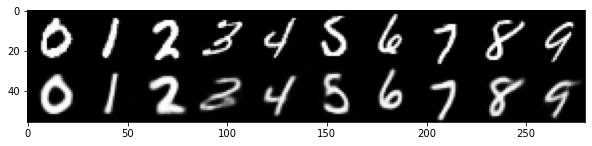

In [33]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [34]:
from XAE.sampler import gaus

exn = 5

In [35]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

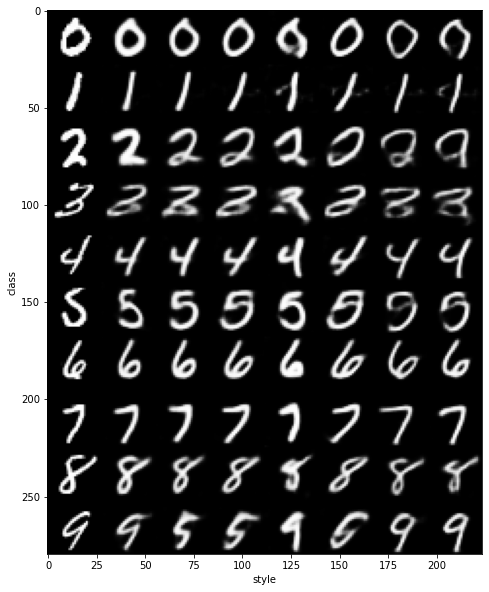

In [36]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [37]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

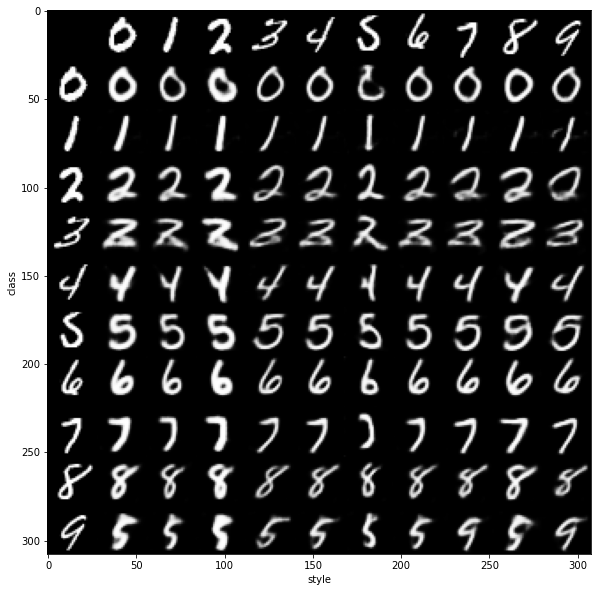

In [38]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()